<span style="color: Gold"> RAG + Cache + Guardrails

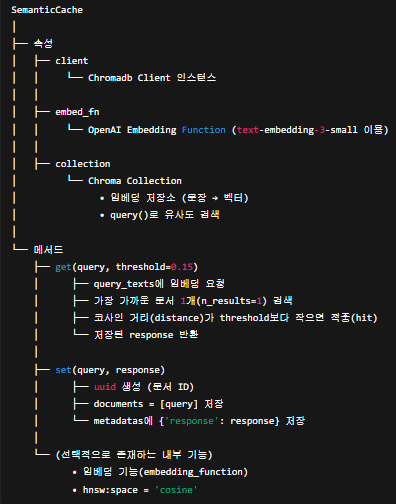

In [17]:
import os
import json
from typing import Dict,Any
import openai
from openai import OpenAI
import chromadb
from chromadb.utils import embedding_functions 
openai.api_key = os.getenv('OPENAI_API_KEY')

class RagSystem:
    '''
    ChromaDB + openai 임베딩
    '''
    def __init__(self, name='temp') :
        self.client = chromadb.Client()                                     # chromaDB 클라이언트
        self.collection = self.client.get_or_create_collection(name=name)   # 컬렉션 객체
        self.embed_fn = embedding_functions.OpenAIEmbeddingFunction(        # OpenAI 임베딩 함수
            api_key = openai.api_key,
            model_name= 'text-embedding-3-small'
        )
        if len(self.collection.get())==0 :
            docs = [
                ('대한민국 수도', '서울입니다.'),
                ('미국 수도', '워싱턴DC입니다.'),
                ('AI 정의', '인간의 지능을 모방한 기술입니다.'),
            ]
            for doc_id , (title,text) in enumerate(docs):
                self.collection.add(                        # 문서를 벡터로 임베딩 후 ChromaDB에 추가
                    documents=[text],
                    metadatas=[{'title':title}],
                    ids= [str(doc_id)],
                    embedding_function = self.embed_fn  # embedding_function : OpenAI 임베딩 함수 사용
                )   
#-------------------------------------------------------------- 문서 준비 백터화

    def query(self, question:str) -> str:           # 질문을 임베딩 → 벡터로 변환
        embedding = self.embed_fn(question)         # 벡터 DB에서 의미 기반 검색에 사용
        results = self.collection.query(            # 컬렉션에서 가장 유사한 문서 1개 검
            query_embeddings = [embedding],
            n_results =1
        )
        if results['documents'][0]:                 # 검색된 문서가 있으면 → RAG 답변으로 반환
            doc_text =results ['documents'][0][0]
            return f'RAG 기반 답변 : {doc_text}'
        else:  # 문서에 없으면                          
            client = OpenAI()                       # 문서에 없으면 LLM 호출
            response = client.chat.completions.creat(
                model = 'gpt-5-nano',
                messages = [{
                    'role':'user',
                    'cotent' :question
                }]
            )
            return response.choices[0].message.content

In [19]:
class CacheSystem:
  def __init__(self) -> None:
    self.l1_cach = SimpleCache()  # 메모리방식 dictionary   완전일치
    self.l2_cach = SemanticCache() # ChoromaDB 벡터DB  유사도방식
  def stats(self):                 # L1 캐시 상태 출력
    print(f'L1 catch: {self.l1_cach.cache}')
  def get(self,key):
    cached = self.l1_cach.get(key)
    if cached:
      print('L1 cache')
      return cached               # L1 캐시 존재하면 반환
    cached = self.l2_cach.get(key)
    if cached:
      print('L2 cache')
      self.l1_cach.set(key,cached)
      return cached              # L2 캐시 존재하면 반환
    # LLM 호출
    print('LLM')
    response = call_llm(key)
    self.l1_cach.set(key,response)
    self.l2_cach.set(key,response)
    return response             # 없으면 LLM 호출 -> L1/L2 캐시에 저장
class GuardrailsSystem: # 사용자 방식
    def __init__(self):
      self.bad_words = ['욕설','비속어','나쁜말']
    def validate_input(self,text:str):     # 입력 검증
        if len(text.strip())==0:
            return False
        for b in self.bad_words:
            if b in text :
                return False, '입력이 허용되지 않는 단어가 포함되어 있습니다.'
        return True, 'ok'
    def validate_output(self, text:str):   # 출력 검증
        for b in self.bad_words:
            if b in text :
                return False, '출력에 허용되지 않는 단어가 포함되어 있습니다.'  
        return True, 'ok'   

class LLMApplication:
    def __init__(self):
      self.rag = RagSystem()    # ← RAG 기반 문서 검색/답변 시스템 (RagSystem 객체)
      self.cache = CacheSystem()
      self.guardrails = GuardrailsSystem()
    def query(self, question:str):
      # 1. 입력 검증
      valid,msg = self.guardrails.validate_input(question)
      if not valid:
        return 'error'
    # 2. 캐시 확인
      cached = self.cache.get(question)
      if cached:
          return cached
    # 3. RAG 실행
      response = self.rag.query(question)
    # 4. 출력 검증  
      valid,msg = self.guardrails.validate_output(response)
      if not valid:
          return 'error'
      self.cache.set(question,response)
      return response
        

In [20]:
# 실행
app = LLMApplication()
question = "대한민국의 수도는 어디인가요?"
answer = app.query(question)
print(answer)

NameError: name 'SimpleCache' is not defined

In [ ]:
questions = [
    "대한민국의 수도는 어디인가요?",
    "한국의 수도는 어디인가요?",
    "프랑스의 수도는?"
]

for q in questions:
    print(app.query(q))

<span style="color: lightblue;"> 1) MultiLevelCache 구조

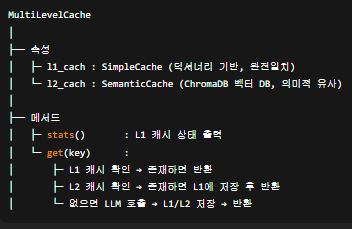

<span style="color: lightblue;"> 2) GuardrailsSystem 구조

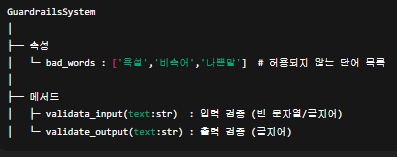

<span style="color: lightblue;"> 3) LLMApplication 구조

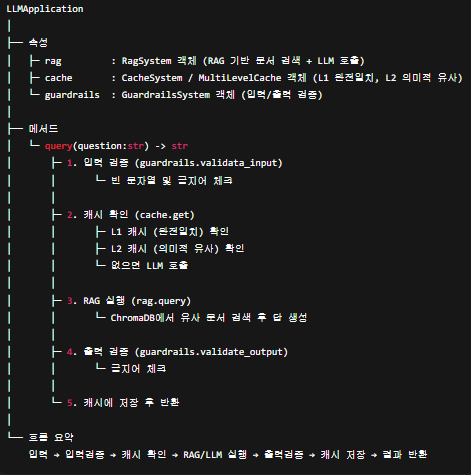
